<a href="https://colab.research.google.com/github/LiadTssf/basil-PCA-api/blob/main/PCA_model_for_PlantTalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import gspread
from oauth2client.service_account import ServiceAccountCredentials


In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Only initialize once
if not firebase_admin._apps:
    cred = credentials.Certificate("firebase-key.json")
    firebase_admin.initialize_app(cred)

db = firestore.client()

# Define path to the logs subcollection
user_id = "l1YnCXx3HMbfBwexMGOvesRK6Bv2"
plant_id = "basilPlant1"
logs_ref = db.collection("users").document(user_id).collection("plants").document(plant_id).collection("logs")

# Fetch all log entries
docs = logs_ref.stream()

# Build dataframe
firebase_data = []
for doc in docs:
    d = doc.to_dict()
    firebase_data.append({
        "moisture": d.get("soilMoisture"),
        "temperature": d.get("temperature"),
        "humidity": d.get("humidity"),
        "timestamp": d.get("timestamp")
    })

df_firebase = pd.DataFrame(firebase_data)

# Preview results
print(df_firebase.shape)
df_firebase.head()


(122, 4)


,moisture,temperature,humidity,timestamp
0,84,25.5,81.5,2025-06-10T10:16:57.153903
1,83,26.0,80.1,2025-06-11T02:39:00.589274
2,38,25.3,84.5,2025-06-14T19:01:08.698187
3,84,27.5,78.9,2025-06-11T19:00:51.915424
4,84,26.8,79.0,2025-06-12T13:25:02.460408


In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import gdown

# Auth
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
file_id = "1EWSzwTQyj9IV7ZfRaufGAv8ugP41GpNG"
output_file = "credentials.json"
# Download from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)
creds = ServiceAccountCredentials.from_json_keyfile_name(output_file, scope)
client = gspread.authorize(creds)

# Load sheet
sheet = client.open("Basil Logger").sheet1
data = sheet.get_all_records()
df = pd.DataFrame(data)
df.columns = df.columns.str.strip()
print(df.columns.tolist())


Downloading...
From: https://drive.google.com/uc?id=1EWSzwTQyj9IV7ZfRaufGAv8ugP41GpNG
To: /content/credentials.json
100%|██████████| 2.35k/2.35k [00:00<00:00, 4.61MB/s]


['timestamp', 'moisture', 'temperature', 'humidity']


In [ ]:
# --- 2. Parse time and engineer time-of-day ---
# --- Parse and clean ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.dropna(subset=['moisture', 'temperature', 'humidity'])
df['Time_of_Day'] = df['timestamp'].dt.hour.apply(lambda h: 0 if 6 <= h < 12 else 1 if 12 <= h < 18 else 2)
#df.loc[df.sample(10).index, 'moisture'] = np.random.choice([40, 50, 70], size=10)

# 1. Ensure timestamp is parsed correctly
df_firebase["timestamp"] = pd.to_datetime(df_firebase["timestamp"], errors='coerce')

# 2. Drop rows missing important values
df_firebase = df_firebase.dropna(subset=["moisture", "temperature", "humidity", "timestamp"])

# 3. Engineer Time_of_Day (0 = morning, 1 = afternoon, 2 = evening/night)
df_firebase["Time_of_Day"] = df_firebase["timestamp"].dt.hour.apply(
    lambda h: 0 if 6 <= h < 12 else 1 if 12 <= h < 18 else 2
    )
# Convert timestamp and drop missing rows
#df = df.dropna()

In [ ]:
def label_status(row):
    moisture = row['moisture']
    temp = row['temperature']
    humidity = row['humidity']

    # 🚰 Thirsty: Very dry or hot+dry conditions
    if moisture < 30 or (temp > 32 and humidity < 40):
        return 'thirsty'

    # 🌊 Overwatered: Saturated soil + high humidity or low temp
    elif moisture > 75 and (humidity > 75 or temp < 20):
        return 'overwatered'

    # 🌱 Healthy: Within ideal growing range for basil
    elif 40 <= moisture <= 70 and 21 <= temp <= 30 and 40 <= humidity <= 70:
        return 'healthy'

    # 🌿 Otherwise: Not ideal but not dangerous → treat as "moderate stress"
    else:
        return 'stressed'

In [ ]:
# Number of synthetic samples to add
n_new = 10

# Define specific moisture values to trigger multiple label types
target_moisture_values = [20, 40, 50, 85]  # includes thirsty, healthy, overwatered

# Generate synthetic environmental data
new_rows = pd.DataFrame({
    'moisture': np.random.choice(target_moisture_values, size=n_new),
    'temperature': np.random.uniform(18, 34, size=n_new),  # broad range to trigger conditions
    'humidity': np.random.uniform(30, 85, size=n_new),     # wide range for labels
    'Time_of_Day': np.random.choice([0, 1, 2], size=n_new) # morning, afternoon, evening
})

# Add dummy timestamps for consistency (optional)
now = pd.Timestamp.now()
new_rows['timestamp'] = [now + pd.Timedelta(minutes=15*i) for i in range(n_new)]

# Label using your logic
new_rows['plant_status'] = new_rows.apply(label_status, axis=1)

# Append to your working dataset
df = pd.concat([df, new_rows], ignore_index=True)

print(f"✅ Added {n_new} synthetic rows:")
print(new_rows[['moisture', 'temperature', 'humidity', 'Time_of_Day', 'plant_status']])

n_thirsty = 10  # Add more if needed
thirsty_rows = pd.DataFrame({
    'moisture': np.random.uniform(10, 25, size=n_thirsty),
    'temperature': np.random.uniform(30, 35, size=n_thirsty),
    'humidity': np.random.uniform(20, 40, size=n_thirsty),
    'Time_of_Day': np.random.choice([0, 1, 2], size=n_thirsty)
})
thirsty_rows['timestamp'] = [pd.Timestamp.now() + pd.Timedelta(minutes=15*i) for i in range(n_thirsty)]
thirsty_rows['plant_status'] = 'thirsty'

df = pd.concat([df, thirsty_rows], ignore_index=True)
print(f"🆕 Added {n_thirsty} targeted 'thirsty' samples.")



✅ Added 10 synthetic rows:
   moisture  temperature   humidity  Time_of_Day plant_status
0        20    24.577603  31.967679            0      thirsty
1        40    23.348202  64.137317            2      healthy
2        40    22.854830  55.055872            2      healthy
3        40    30.532970  63.376496            1     stressed
4        20    28.205561  76.407564            1      thirsty
5        20    22.187118  44.713984            2      thirsty
6        50    22.129071  42.413515            0      healthy
7        20    33.041300  79.047606            0      thirsty
8        50    33.533938  76.940585            0     stressed
9        85    29.028865  81.458913            1  overwatered
🆕 Added 10 targeted 'thirsty' samples.


In [ ]:
# --- Refined multi-variable labeling ---
df['moisture'] = pd.to_numeric(df['moisture'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
def label_status(row):
    moisture = row['moisture']
    temp = row['temperature']
    humidity = row['humidity']

    # Thirsty: Very dry or hot+dry conditions
    if moisture < 30 or (temp > 32 and humidity < 40):
        return 'thirsty'

    # Overwatered: Saturated soil + high humidity or low temp
    elif moisture > 75 and (humidity > 75 or temp < 20):
        return 'overwatered'

    # Healthy: Within ideal growing range for basil
    elif 40 <= moisture <= 70 and 21 <= temp <= 30 and 40 <= humidity <= 70:
        return 'healthy'

    # Otherwise: Not ideal but not dangerous → treat as "moderate stress"
    else:
        return 'stressed'

df['plant_status'] = df.apply(label_status, axis=1)
df_firebase["plant_status"] = df_firebase.apply(label_status, axis=1)

df_combined = pd.concat([df, df_firebase], ignore_index=True)
df_combined = df_combined.dropna(subset=["moisture", "temperature", "humidity", "status","plant_status"])
df_combined = df.reset_index(drop=True)

In [ ]:
# --- 4. Feature selection ---
# Force columns to numeric and coerce errors (e.g. '' → NaN)
# --- Prepare features ---
features = ['moisture', 'temperature', 'humidity', 'Time_of_Day']
X = df_combined[features].apply(pd.to_numeric, errors='coerce').dropna()
y = df_combined.loc[X.index, 'plant_status']

print("🔍 Final cleaned DataFrame used for PCA and model training:")
print(X.head())
print("Shape:", X.shape)
print(y.shape)
print(y.head())

🔍 Final cleaned DataFrame used for PCA and model training:
   moisture  temperature  humidity  Time_of_Day
0      56.0         24.8      48.3            2
1      56.0         24.9      47.1            2
2      56.0         24.5      51.7            2
3      56.0         24.4      55.1            2
4      56.0         24.1      54.7            2
Shape: (578, 4)
(578,)
0    healthy
1    healthy
2    healthy
3    healthy
4    healthy
Name: plant_status, dtype: object


In [ ]:
# --- PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_ * 100)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_ * 100
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

[42.15467013 25.11507856 22.09066464]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- 6. Train classifier ---
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)




y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9051724137931034
              precision    recall  f1-score   support

     healthy       0.67      0.88      0.76        16
 overwatered       0.92      1.00      0.96        12
    stressed       0.96      0.93      0.94        83
     thirsty       1.00      0.40      0.57         5

    accuracy                           0.91       116
   macro avg       0.89      0.80      0.81       116
weighted avg       0.92      0.91      0.90       116



In [ ]:
import joblib
# --- 7. Save models ---
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca_transform.pkl')
joblib.dump(clf, 'plant_health_model.pkl')


['plant_health_model.pkl']

In [ ]:
# --- 8. Scree + Biplot ---
explained_var = pca.explained_variance_ratio_ * 100
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


What it shows:
This chart displays how much variance each Principal Component (PC) explains.

PC1 explains the most variance (~42%)

PC2 adds about ~26%

PC3 adds another ~22%

Together, PC1 + PC2 + PC3 explain ~90% of the total variance in the dataset.

Why it matters for basil:
It means we can reduce the feature space from 4 variables to just 3 dimensions without losing much information.
Using 3 PCs helps preserve the structure and complexity of the data — which is important for detecting subtle environmental effects on basil plant health.

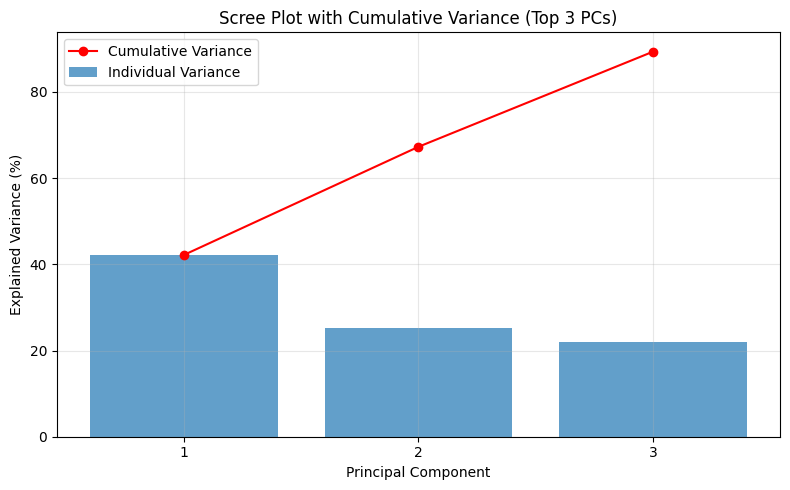

In [ ]:
# 1. Scree plot (only PC1 and PC2)
plt.figure(figsize=(8, 5))
plt.bar(range(1, 4), explained_var[:3], alpha=0.7, label="Individual Variance")
plt.plot(range(1, 4), np.cumsum(explained_var[:3]), 'ro-', label="Cumulative Variance")
plt.title("Scree Plot with Cumulative Variance (Top 3 PCs)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


What it shows:
This matrix displays the linear correlation between all input features.

Temperature and humidity are moderately negatively correlated (-0.54), which makes sense: as temperature rises, relative humidity tends to drop — a common pattern in natural environments.

Moisture has weak positive correlations with humidity (0.24) and almost no correlation with temperature (-0.04) or Time_of_Day (0.02).

Time_of_Day is weakly correlated with all other features, suggesting its influence may be indirect or contextual (e.g., daily cycles).

Why it matters for basil:
This helps identify which variables provide distinct information.

The temperature–humidity relationship supports known physical principles in plant environments.

The weak correlations of moisture and Time_of_Day suggest they capture unique variance — valuable when building predictive models for basil health.



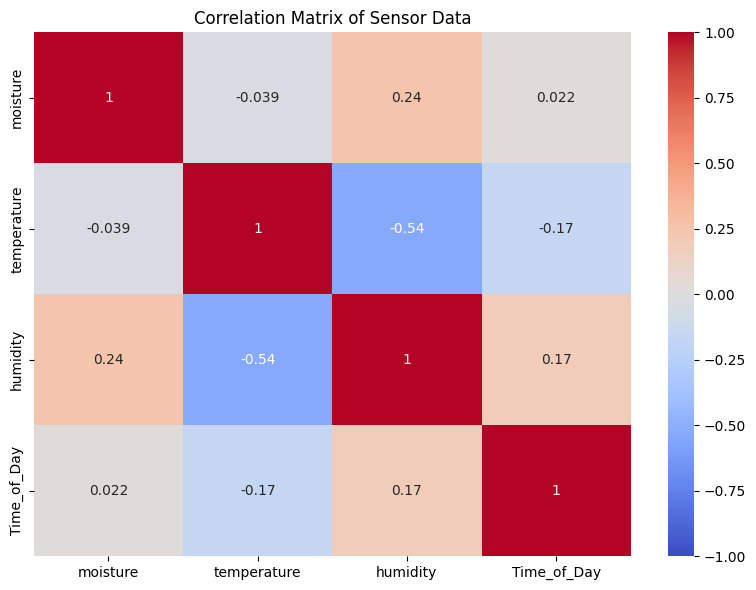

In [ ]:
# 2. Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Sensor Data")
plt.tight_layout()
plt.show()

What it shows:
Each cell shows how strongly a variable contributes (or loads) onto a Principal Component (PC). These loadings help interpret what each PC is capturing.

PC1 is mainly defined by humidity (+0.66) and temperature (−0.61) — this suggests PC1 reflects a moisture–heat balance.

PC2 is dominated by moisture (+0.84), indicating it's focused on soil moisture variation.

PC3 is strongly influenced by Time_of_Day (+0.8), representing daily or circadian effects.

Why it matters for basil:

PC1 likely captures general climate stress (e.g., hot and dry vs. cool and humid conditions).

PC2 isolates differences in soil hydration, which directly impacts irrigation needs.

PC3 separates data by time of day — important for interpreting sensor patterns that fluctuate across the day (e.g., sunlight or evaporation cycles).

This decomposition helps the model focus on distinct ecological dynamics relevant to basil health.

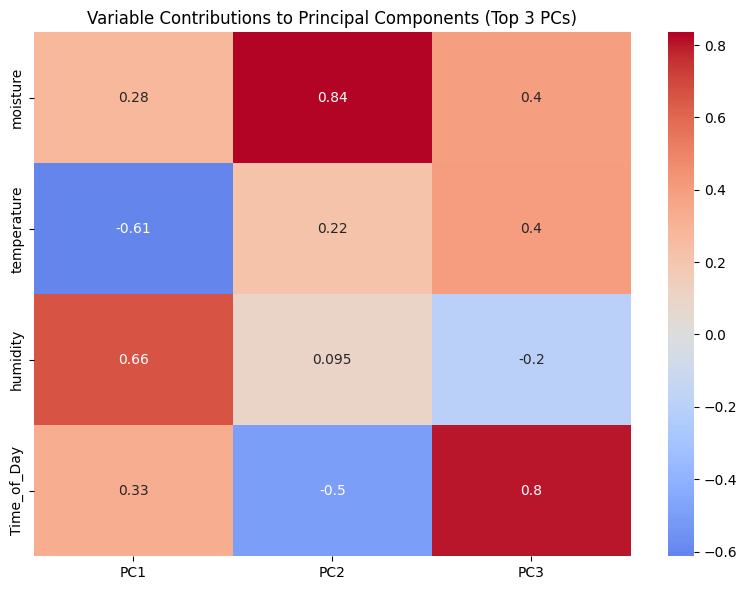

In [ ]:
# 2. Loadings heatmap (PC1 and PC2 only)
load_df = pd.DataFrame(pca.components_[:3].T, columns=["PC1", "PC2", "PC3"], index=features)
plt.figure(figsize=(8, 6))
sns.heatmap(load_df, annot=True, cmap="coolwarm", center=0)
plt.title("Variable Contributions to Principal Components (Top 3 PCs)")
plt.tight_layout()
plt.show()

In [ ]:
# Biplot
pc_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pc_df["Label"] = y

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="Label", palette="Set2")
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='black', alpha=0.6)
    plt.text(loadings[i, 0]*1.2, loadings[i, 1]*1.2, feature, color='black')
plt.title("PCA Biplot for Basil Logger")
plt.grid()
plt.show()

ValueError: Shape of passed values is (578, 3), indices imply (578, 2)

What it shows:
Each dot represents a single sensor reading, colored by its classified plant health status (e.g., Thirsty, Healthy, Overwatered, Stressed).
The arrows represent the direction and strength (loading) of each original variable in PCA space:

Longer arrows = stronger influence on the PCs.

Arrow direction = how the variable separates data along principal axes.

What you can observe:

Humidity and moisture vectors point toward the Overwatered cluster (blue), suggesting they are key indicators of that condition.

Stressed readings (orange) are more spread, often appearing where temperature is higher and humidity is lower, confirming environmental imbalance.

Thirsty samples (red) are positioned far from high-moisture zones, aligning with low moisture and temperature-driven dryness.

Time_of_Day spreads primarily along PC3, confirming that measurement timing adds meaningful separation, especially for borderline cases.



Why it matters for basil:
This plot visually confirms that moisture, humidity, and temperature are the main drivers of basil plant health — consistent with known agronomic knowledge.
It also shows that using 3 principal components captures distinct ecological patterns, making the classification more accurate and explainable.

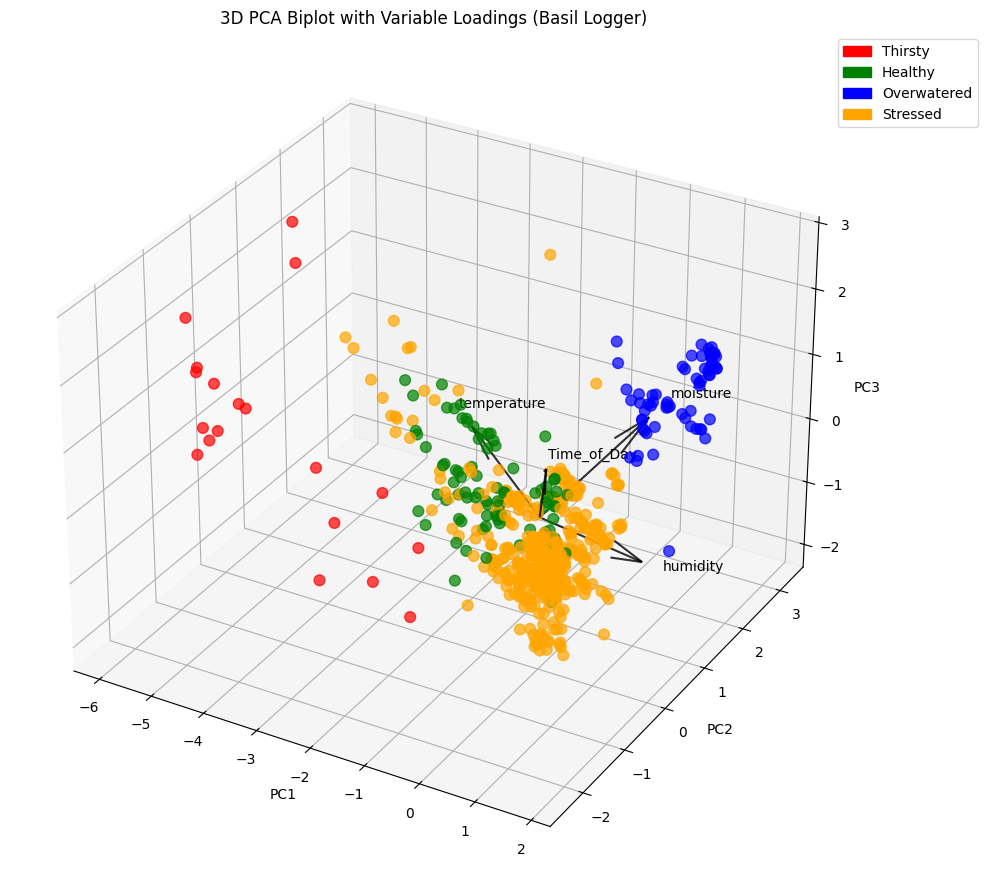

In [ ]:
# 4. 3D PCA plot with legend
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Color mapping based on plant status
colors = {'thirsty': 'red', 'healthy': 'green', 'overwatered': 'blue', 'stressed': 'orange'}
statuses = list(colors.keys())

# Plot PCA points
ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=[colors.get(label, 'gray') for label in y],
    s=60, alpha=0.7
)

# Axes and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Biplot with Variable Loadings (Basil Logger)")

# Add feature vectors as arrows
scaling_factor = 2
for i, feature in enumerate(features):
    ax.quiver(0, 0, 0,
              loadings[i, 0]*scaling_factor,
              loadings[i, 1]*scaling_factor,
              loadings[i, 2]*scaling_factor,
              color='black', alpha=0.8)
    ax.text(loadings[i, 0]*scaling_factor*1.2,
            loadings[i, 1]*scaling_factor*1.2,
            loadings[i, 2]*scaling_factor*1.2,
            feature, color='black')

# Add custom legend
legend_patches = [mpatches.Patch(color=color, label=status.capitalize()) for status, color in colors.items()]
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


Red ("Thirsty"): The plant's moisture or humidity levels are too low. It likely requires immediate watering.

Green ("Healthy"): Optimal conditions for basil growth — proper moisture, temperature, and humidity.

Blue ("Overwatered"): Excessive soil moisture or air humidity, potentially leading to root rot or fungal issues.

Orange ("Stressed"): A combination of factors like high humidity, fluctuating temperature, or borderline moisture levels that indicate suboptimal conditions.